In [16]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import numpy as np
import pickle
from scipy.io import loadmat


from tensorflow.keras.layers import Input
from tensorflow.keras.models import load_model
from keras.datasets import mnist

from architectures.protoshotxai import ProtoShotXAI
from utils.ploting_function import xai_plot

In [2]:
model_path_pretrained = '../trained_models/pretrained_conv_omni/'
base_model = load_model(model_path_pretrained)

In [19]:
x_train = np.load('../data/train.npy')
class_val = 64640
# Reorder sample_indx use index 4 as query, the rest of the 18 samples are used for support
sample_idx = [4, 1, 2, 3, 0, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15 ,16 ,17, 18] 
samples = x_train[class_val][sample_idx]/255
query = samples[0]
query = np.expand_dims(query,axis=0)
support_data = samples[1:]

In [10]:
protoshot = ProtoShotXAI(base_model,feature_layer=-1,class_layer=None)
ref_pixel = [1]

In [11]:
protoshot_attributions = protoshot.image_feature_attribution(support_data, query, None, ref_pixel, pad=1)

100%|██████████| 28/28 [00:00<00:00, 71.48it/s]


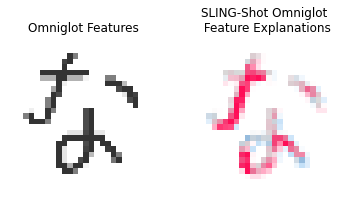

In [13]:
import matplotlib.pyplot as plt
import utils.shap_color_scheme.colors as colors

abs_vals = np.abs(protoshot_attributions).flatten()
max_val = np.nanpercentile(abs_vals, 99)
fig, m_axs = plt.subplots(1,2, figsize = (6,3))
for i, c_ax in enumerate(m_axs.flatten()):
    if i == 0:
        c_ax.imshow(query[0]-1, interpolation = 'nearest', cmap='gray', alpha=0.8)
        c_ax.set_title('Omniglot Features')
        c_ax.axis('off')
    else:
        c_ax.imshow(query[0]-1, interpolation = 'nearest', cmap='gray', alpha=0.15)
        im = c_ax.imshow(protoshot_attributions, cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
        c_ax.set_title('SLING-Shot Omniglot \n Feature Explanations')
        c_ax.axis('off')
plt.savefig('./results/Omniglot/Omniglot_Features.png', dpi=450)


In [20]:


query = np.expand_dims(np.copy(query),axis=0)
support_data = np.expand_dims(support_data,axis=0)
matdata = loadmat('../data/omniglot_sample_revized.mat')
base_score = protoshot.compute_score(support_data,query,None)
print(base_score)
modified_query = np.zeros_like(query)
modified_query[0,0,:,:,0] = matdata['input_ex1']
remove_feature_1_score = protoshot.compute_score(support_data,modified_query,None)
print(remove_feature_1_score)
modified_query[0,0,:,:,0] = matdata['input_ex2']
remove_feature_2_score = protoshot.compute_score(support_data,modified_query,None)
print(remove_feature_2_score)
modified_query[0,0,:,:,0] = matdata['input_ex3']
remove_feature_3_score = protoshot.compute_score(support_data,modified_query,None)
print(remove_feature_3_score)

0.9543636
0.84555763
0.9279544
0.90548617


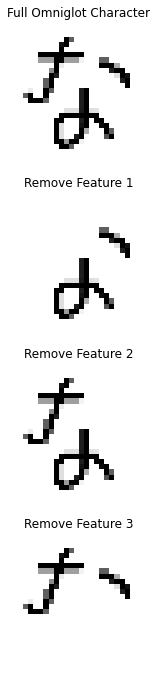

In [23]:
import matplotlib.pyplot as plt
import utils.shap_color_scheme.colors as colors

fig, m_axs = plt.subplots(4,1, figsize = (3,12))
for i, c_ax in enumerate(m_axs.flatten()):
    if i == 0:
        c_ax.imshow(query[0,0,:,:,:], interpolation = 'nearest', cmap='gray', alpha=1)
        c_ax.set_title('Full Omniglot Character')
        c_ax.axis('off')
    elif i == 1:
        c_ax.imshow(matdata['input_ex1'], interpolation = 'nearest', cmap='gray', alpha=1)
        c_ax.set_title('Remove Feature 1')
        c_ax.axis('off')
    elif i == 2:
        c_ax.imshow(matdata['input_ex2'], interpolation = 'nearest', cmap='gray', alpha=1)
        c_ax.set_title('Remove Feature 2')
        c_ax.axis('off')
    else:
        c_ax.imshow(matdata['input_ex3'], interpolation = 'nearest', cmap='gray', alpha=1)
        c_ax.set_title('Remove Feature 3')
        c_ax.axis('off')
plt.savefig('./results/Omniglot/Omniglot_Large_Feature_Removal.png', dpi=450)
